<a href="https://colab.research.google.com/github/anhhaibkhn/Machine-Learning-Mastery-Notes/blob/master/How_to_Grid_Search_Deep_Learning_Models_for_Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## How to develop a framework to grid search `hyperparameters` for deep learning models - [Source](https://machinelearningmastery.com/how-to-grid-search-deep-learning-models-for-time-series-forecasting/)

What to learn:

* How to develop `a generic grid searching framework` for tuning model hyperparameters.
* How to `grid search hyperparameters` for a `Multilayer Perceptron` model on the airline passengers univariate time series forecasting problem.
* How to adapt the framework to grid search hyperparameters for `convolutional` and `long short-term memory` neural networks.

Overview:

1. Time Series Problem
2. Grid Search Framework
3. Grid Search Multilayer Perceptron
4. Grid Search Convolutional Neural Network
5. Grid Search Long Short-Term Memory Networ

### 1. Time Series Problem

- [Dataset](https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv)  filename ‘monthly-airline-passengers.csv‘ 

- The dataset is monthly and has `12 years`, or `144 observation`s. In our testing, we will use the `last year`, or `12 observations`, as the test set.

- A line plot is created. The dataset has an obvious trend and seasonal component. The period of the seasonal component is 12 months.

(144, 1)


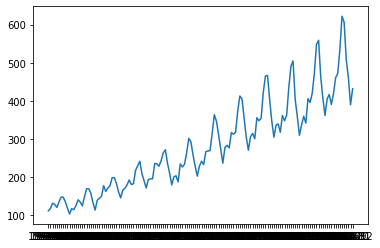

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'

# load
series = pd.read_csv(url, header=0, index_col=0)

# summarize shape
print(series.shape)
# plot
plt.plot(series)
plt.show()

In this tutorial, we will introduce the t`ools for grid searching`, but we will not optimize the model hyperparameters for this problem. Instead, we will demonstrate how to grid search the deep learning model hyperparameters generally and find models with some skill compared to a naive mode

### 2. Grid Search Framework

* Train-Test Split
* Series as Supervised Learning
* Walk-Forward Validation
* Repeat Evaluation
* Summarize Performance
* Worked Example

In [7]:
# grid search persistence models for airline passengers
from math import sqrt
from numpy import mean
from pandas import read_csv
from sklearn.metrics import mean_squared_error

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit(train, config):
	return None

# forecast with a pre-fit model
def model_predict(model, history, offset):
	return history[-offset]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return error

# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
	# convert config to a key
	key = str(config)
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	# summarize score
	result = mean(scores)
	print('> Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test):
	# evaluate configs
	scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# define dataset
# series = read_csv('monthly-airline-passengers.csv', header=0, index_col=0)
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
series = pd.read_csv(url, header=0, index_col=0)

data = series.values
# data split
n_test = 12
# model configs
cfg_list = [1, 6, 12, 24, 36]
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 10 configs
for cfg, error in scores[:10]:
	print(cfg, error)

 > 53.152
 > 53.152
 > 53.152
 > 53.152
 > 53.152
 > 53.152
 > 53.152
 > 53.152
 > 53.152
 > 53.152
> Model[1] 53.152
 > 126.735
 > 126.735
 > 126.735
 > 126.735
 > 126.735
 > 126.735
 > 126.735
 > 126.735
 > 126.735
 > 126.735
> Model[6] 126.735
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
> Model[12] 50.708
 > 97.110
 > 97.110
 > 97.110
 > 97.110
 > 97.110
 > 97.110
 > 97.110
 > 97.110
 > 97.110
 > 97.110
> Model[24] 97.110
 > 110.274
 > 110.274
 > 110.274
 > 110.274
 > 110.274
 > 110.274
 > 110.274
 > 110.274
 > 110.274
 > 110.274
> Model[36] 110.274
done
12 50.708316214732804
1 53.1515129919491
24 97.10990337413241
36 110.27352356753639
6 126.73495965991387


### 3. Grid Search Multilayer Perceptron

* n_input: The number of prior inputs to use as input for the model (e.g. 12 months).
* n_nodes: The number of nodes to use in the hidden layer (e.g. 50).
* n_epochs: The number of training epochs (e.g. 1000).
* n_batch: The number of samples to include in each mini-batch (e.g. 32).
* n_diff: The difference order (e.g. 0 or 12).

In [9]:
# grid search mlps for airline passengers
from math import sqrt
from numpy import array
from numpy import mean
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, order):
	return [data[i] - data[i - order] for i in range(order, len(data))]

# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_nodes, n_epochs, n_batch, n_diff = config
	# prepare data
	if n_diff > 0:
		train = difference(train, n_diff)
	# transform series into supervised format
	data = series_to_supervised(train, n_in=n_input)
	# separate inputs and outputs
	train_x, train_y = data[:, :-1], data[:, -1]
	# define model
	model = Sequential()
	model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit model
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model

# forecast with the fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _, n_diff = config
	# prepare data
	correction = 0.0
	if n_diff > 0:
		correction = history[-n_diff]
		history = difference(history, n_diff)
	# shape input for model
	x_input = array(history[-n_input:]).reshape((1, n_input))
	# make forecast
	yhat = model.predict(x_input, verbose=0)
	# correct forecast if it was differenced
	return correction + yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return error

# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
	# convert config to a key
	key = str(config)
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	# summarize score
	result = mean(scores)
	print('> Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test):
	# evaluate configs
	scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a list of configs to try
def model_configs():
	# define scope of configs
	n_input = [12]
	n_nodes = [50, 100]
	n_epochs = [100]
	n_batch = [1, 150]
	n_diff = [0, 12]
	# create configs
	configs = list()
	for i in n_input:
		for j in n_nodes:
			for k in n_epochs:
				for l in n_batch:
					for m in n_diff:
						cfg = [i, j, k, l, m]
						configs.append(cfg)
	print('Total configs: %d' % len(configs))
	return configs

# define dataset
# series = read_csv('monthly-airline-passengers.csv', header=0, index_col=0)
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
series = pd.read_csv(url, header=0, index_col=0)
data = series.values
# data split
n_test = 12
# model configs
cfg_list = model_configs()
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
	print(cfg, error)

Total configs: 8
 > 25.644
 > 22.437
 > 17.489
 > 27.822
 > 19.192
 > 17.197
 > 25.273
 > 22.596
 > 20.946
 > 25.940
> Model[[12, 50, 100, 1, 0]] 22.454
 > 21.269
 > 20.049
 > 20.612
 > 19.473
 > 21.815
 > 18.263
 > 19.072
 > 19.765
 > 22.189
 > 20.788
> Model[[12, 50, 100, 1, 12]] 20.329
 > 43.745
 > 80.342
 > 57.575
 > 29.581
 > 71.344
 > 63.395
 > 91.728
 > 77.317
 > 63.083
 > 23.079
> Model[[12, 50, 100, 150, 0]] 60.119
 > 17.429
 > 20.912
 > 18.126
 > 18.891
 > 19.734
 > 18.876
 > 21.052
 > 19.256
 > 21.411
 > 18.041
> Model[[12, 50, 100, 150, 12]] 19.373
 > 25.916
 > 24.010
 > 24.205
 > 20.943
 > 20.921
 > 18.780
 > 19.388
 > 16.436
 > 16.846
 > 16.361
> Model[[12, 100, 100, 1, 0]] 20.381
 > 19.018
 > 20.638
 > 17.163
 > 20.504
 > 18.533
 > 20.067
 > 19.142
 > 19.913
 > 19.772
 > 20.364
> Model[[12, 100, 100, 1, 12]] 19.511
 > 42.532
 > 40.533
 > 73.005
 > 53.644
 > 77.457
 > 47.065
 > 50.787
 > 47.670
 > 68.286
 > 67.953
> Model[[12, 100, 100, 150, 0]] 56.893
 > 18.981
 > 19.171

### 4. Grid Search Convolutional Neural Network

The chosen set of hyperparameters to grid search in the CNN model are as follows:

* n_input: The number of prior inputs to use as input for the model (e.g. 12 months).
* n_filters: The number of filter maps in the convolutional layer (e.g. 32).
* n_kernel: The kernel size in the convolutional layer (e.g. 3).
* n_epochs: The number of training epochs (e.g. 1000).
* n_batch: The number of samples to include in each mini-batch (e.g. 32).
* n_diff: The difference order (e.g. 0 or 12).

In [10]:
# grid search cnn for airline passengers
from math import sqrt
from numpy import array
from numpy import mean
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, order):
	return [data[i] - data[i - order] for i in range(order, len(data))]

# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_filters, n_kernel, n_epochs, n_batch, n_diff = config
	# prepare data
	if n_diff > 0:
		train = difference(train, n_diff)
	# transform series into supervised format
	data = series_to_supervised(train, n_in=n_input)
	# separate inputs and outputs
	train_x, train_y = data[:, :-1], data[:, -1]
	# reshape input data into [samples, timesteps, features]
	n_features = 1
	train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
	# define model
	model = Sequential()
	model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu', input_shape=(n_input, n_features)))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model

# forecast with the fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _, _, n_diff = config
	# prepare data
	correction = 0.0
	if n_diff > 0:
		correction = history[-n_diff]
		history = difference(history, n_diff)
	x_input = array(history[-n_input:]).reshape((1, n_input, 1))
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return correction + yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return error

# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
	# convert config to a key
	key = str(config)
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	# summarize score
	result = mean(scores)
	print('> Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test):
	# evaluate configs
	scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a list of configs to try
def model_configs():
	# define scope of configs
	n_input = [12]
	n_filters = [64]
	n_kernels = [3, 5]
	n_epochs = [100]
	n_batch = [1, 150]
	n_diff = [0, 12]
	# create configs
	configs = list()
	for a in n_input:
		for b in n_filters:
			for c in n_kernels:
				for d in n_epochs:
					for e in n_batch:
						for f in n_diff:
							cfg = [a,b,c,d,e,f]
							configs.append(cfg)
	print('Total configs: %d' % len(configs))
	return configs

# define dataset
# series = read_csv('monthly-airline-passengers.csv', header=0, index_col=0)
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
series = pd.read_csv(url, header=0, index_col=0)
data = series.values

# data split
n_test = 12
# model configs
cfg_list = model_configs()
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 10 configs
for cfg, error in scores[:3]:
	print(cfg, error)

Total configs: 8
 > 37.631
 > 16.832
 > 26.690
 > 17.805
 > 17.017
 > 16.539
 > 20.637
 > 17.346
 > 19.508
 > 20.067
> Model[[12, 64, 3, 100, 1, 0]] 21.007
 > 19.297
 > 20.156
 > 21.370
 > 20.609
 > 18.777
 > 22.055
 > 20.454
 > 21.073
 > 20.096
 > 20.711
> Model[[12, 64, 3, 100, 1, 12]] 20.460
 > 75.132
 > 87.957
 > 78.806
 > 85.172
 > 79.355
 > 81.527
 > 79.462
 > 73.727
 > 68.296
 > 73.533
> Model[[12, 64, 3, 100, 150, 0]] 78.297
 > 18.668
 > 19.348
 > 17.962
 > 18.892
 > 19.835
 > 18.828
 > 19.012
 > 17.887
 > 18.649
 > 20.219
> Model[[12, 64, 3, 100, 150, 12]] 18.930
 > 21.269
 > 25.380
 > 31.234
 > 18.035
 > 18.854
 > 29.764
 > 20.044
 > 18.196
 > 19.716
 > 19.408
> Model[[12, 64, 5, 100, 1, 0]] 22.190
 > 17.775
 > 19.020
 > 19.271
 > 18.115
 > 19.588
 > 18.654
 > 20.049
 > 19.624
 > 19.091
 > 18.507
> Model[[12, 64, 5, 100, 1, 12]] 18.969
 > 73.491
 > 87.211
 > 74.136
 > 72.863
 > 82.885
 > 88.219
 > 86.279
 > 90.976
 > 70.185
 > 79.105
> Model[[12, 64, 5, 100, 150, 0]] 80.535
 

### 5. Grid Search Long Short-Term Memory Network

* n_input: The number of prior inputs to use as input for the model (e.g. 12 months).
* n_nodes: The number of nodes to use in the hidden layer (e.g. 50).
* n_epochs: The number of training epochs (e.g. 1000).
* n_batch: The number of samples to include in each mini-batch (e.g. 32).
* n_diff: The difference order (e.g. 0 or 12)

In [ ]:
# grid search lstm for airline passengers
from math import sqrt
from numpy import array
from numpy import mean
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, order):
	return [data[i] - data[i - order] for i in range(order, len(data))]

# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_nodes, n_epochs, n_batch, n_diff = config
	# prepare data
	if n_diff > 0:
		train = difference(train, n_diff)
	# transform series into supervised format
	data = series_to_supervised(train, n_in=n_input)
	# separate inputs and outputs
	train_x, train_y = data[:, :-1], data[:, -1]
	# reshape input data into [samples, timesteps, features]
	n_features = 1
	train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
	# define model
	model = Sequential()
	model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, n_features)))
	model.add(Dense(n_nodes, activation='relu'))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit model
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model

# forecast with the fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _, n_diff = config
	# prepare data
	correction = 0.0
	if n_diff > 0:
		correction = history[-n_diff]
		history = difference(history, n_diff)
	# reshape sample into [samples, timesteps, features]
	x_input = array(history[-n_input:]).reshape((1, n_input, 1))
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return correction + yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return error

# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
	# convert config to a key
	key = str(config)
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	# summarize score
	result = mean(scores)
	print('> Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test):
	# evaluate configs
	scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a list of configs to try
def model_configs():
	# define scope of configs
	n_input = [12]
	n_nodes = [100]
	n_epochs = [50]
	n_batch = [1, 150]
	n_diff = [12]
	# create configs
	configs = list()
	for i in n_input:
		for j in n_nodes:
			for k in n_epochs:
				for l in n_batch:
					for m in n_diff:
						cfg = [i, j, k, l, m]
						configs.append(cfg)
	print('Total configs: %d' % len(configs))
	return configs

# define dataset
# series = read_csv('monthly-airline-passengers.csv', header=0, index_col=0)
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
series = pd.read_csv(url, header=0, index_col=0)
data = series.values
# data split
n_test = 12
# model configs
cfg_list = model_configs()
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 10 configs
for cfg, error in scores[:3]:
	print(cfg, error)

The model requires a lot more tuning and may do much better with a hybrid configuration, such as having a CNN model as input.

We can unpack this configuration as:

* n_input: 12
* n_nodes: 100
* n_epochs: 50
* n_batch: 1
* n_diff: 12


#### [Further reading](https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/)